In [2]:
#import pictures from drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/My Drive/Data/skin-cancer-malignant-vs-benign.zip" -d "/content/drive/My Drive/Data"

In [ ]:
#Upgrade memory - high RAM run time
#a = []
#while(1):
   # a.append(‘1’)

In [4]:
#Import some necessary Modules
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [6]:
#loading pictures 
def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/My Drive/Data/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/My Drive/Data/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/My Drive/Data/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/My Drive/Data/test/malignant',224))

100%|██████████| 300/300 [00:00<00:00, 309.96it/s]


In [7]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# Split validation data from train data
x_train=X_train[500:]
x_val=X_train[:500]
y_train=Y_train[500:]
y_val=Y_train[:500]

In [8]:
X_test.shape, x_val.shape, x_train.shape

((660, 224, 224, 3), (500, 224, 224, 3), (2137, 224, 224, 3))

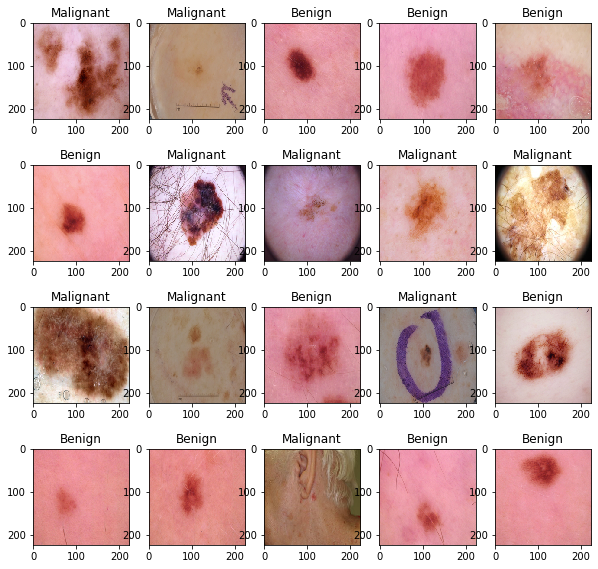

In [9]:
# Display first 20 images of moles

fig=plt.figure(figsize=(10, 10))

for i in range(1, 20 +1):
    ax = fig.add_subplot(4, 5, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [10]:
# one hot encoding 
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encodin
y_train = to_categorical(y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
y_val = to_categorical(y_val, num_classes= 2)

In [11]:
# normalization 
x_train = x_train/255.
X_test = X_test/255.
x_val = x_val/255.

In [12]:
X_test.shape, x_val.shape, x_train.shape

((660, 224, 224, 3), (500, 224, 224, 3), (2137, 224, 224, 3))

In [13]:
# data augmentation - cut out 

import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [14]:
# data augmentation 

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(p=0.5, v_h=0, s_h=0.25))

In [15]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

TensorFlow is already loaded. Please restart the runtime to change versions.


In [17]:
# building the model 

!pip install -U efficientnet
from keras import layers
import efficientnet.keras as efn
from keras import regularizers 

eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model=Sequential()
model.add(eff_net)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

"""
alpha = 1e-3  # weight decay coefficient
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
"""
model.summary()

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 4,214,302
T

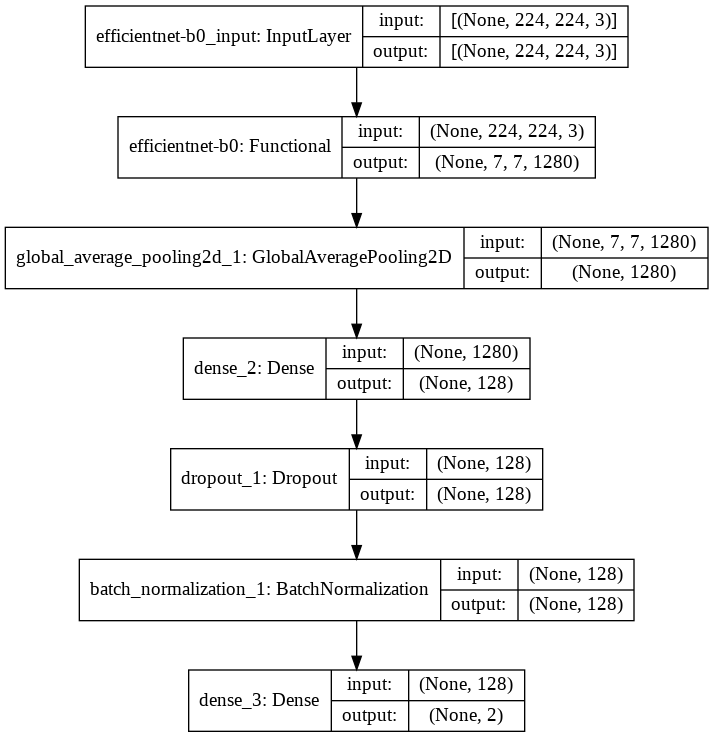

In [18]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
# callback - if accuracy doesn't improve after 3 epoch then reduce lr by factor 0.5 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=3, min_lr=0.000005)

In [24]:
# train the model 
optimizer=optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy'])
h = model.fit(x_train,y_train, batch_size=64,epochs=100,callbacks=[reduce_lr])

Epoch 1/100
34/34 [==============================] - 22s 378ms/step - loss: 0.2234 - accuracy: 0.9065
Epoch 2/100
34/34 [==============================] - 13s 375ms/step - loss: 0.1476 - accuracy: 0.9485
Epoch 3/100
34/34 [==============================] - 13s 376ms/step - loss: 0.1039 - accuracy: 0.9539
Epoch 4/100
34/34 [==============================] - 13s 374ms/step - loss: 0.1021 - accuracy: 0.9662
Epoch 5/100
34/34 [==============================] - 13s 380ms/step - loss: 0.0671 - accuracy: 0.9825
Epoch 6/100
34/34 [==============================] - 13s 376ms/step - loss: 0.0456 - accuracy: 0.9859
Epoch 7/100
34/34 [==============================] - 13s 376ms/step - loss: 0.0751 - accuracy: 0.9720
Epoch 8/100
34/34 [==============================] - 13s 373ms/step - loss: 0.0856 - accuracy: 0.9718
Epoch 9/100
34/34 [==============================] - 13s 374ms/step - loss: 0.0334 - accuracy: 0.9882
Epoch 10/100
34/34 [==============================] - 13s 370ms/step - loss: 0.044

Text(0.5, 1.0, 'Loss & Validation Loss')

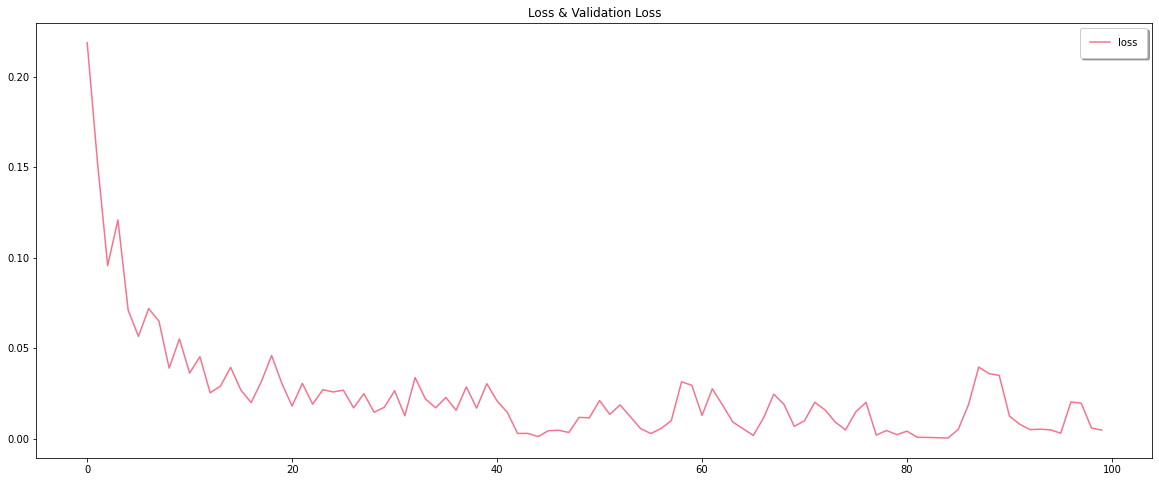

In [26]:
# loss and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(h.history['loss'],color="#F7728B", label='loss')
#plt.plot(h.history['val_loss'], color="#3CA3EC", label='validation loss')
plt.legend(loc="upper right",fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.title(label="Loss & Validation Loss")

Text(0.5, 1.0, 'Accuracy & Validation Accuracy')

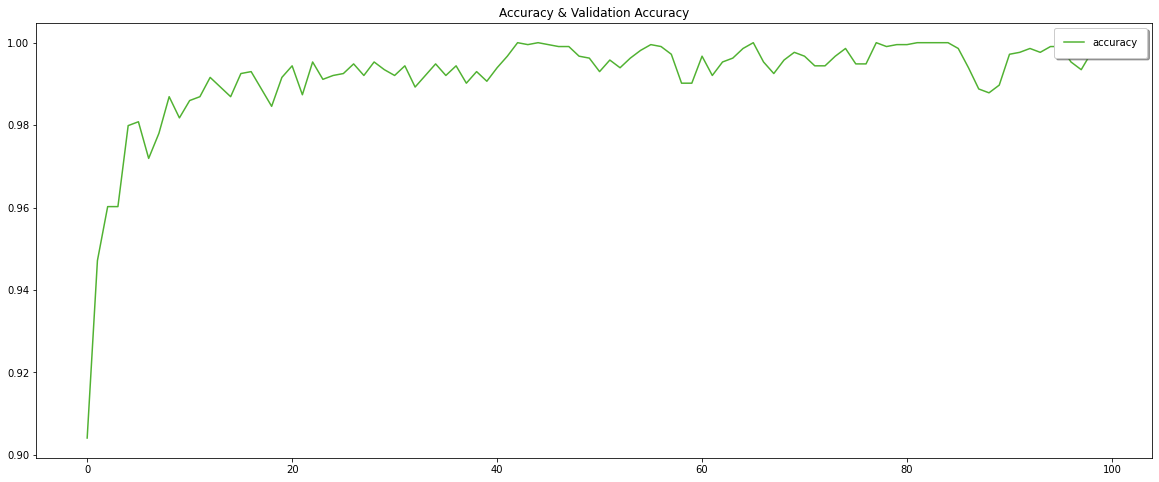

In [27]:
# accuracy and validation accuracy
plt.figure(figsize=(20,8))
plt.plot(h.history['accuracy'],color="#51B232", label='accuracy')
#plt.plot(h.history['val_accuracy'], color="#CF8F32", label='validation accuracy')
plt.legend(loc="upper right",fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.title(label="Accuracy & Validation Accuracy")

In [28]:
# test the model 
results = model.evaluate(X_test, Y_test, batch_size=64)
print('test loss',results[0], 'test acc:',results[1])
results

11/11 [==============================] - 2s 79ms/step - loss: 0.5796 - accuracy: 0.8667
test loss 0.5796362161636353 test acc: 0.8666666746139526


[0.5796362161636353, 0.8666666746139526]

In [29]:
# test the model
y_pred = model.predict(X_test, batch_size=64)
print(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

0.8666666666666667


In [34]:
y_pred[0], y_pred[0][0],y_pred[0][1]

(array([6.0941994e-07, 9.9999940e-01], dtype=float32),
 6.0941994e-07,
 0.9999994)

In [31]:
#Confution Matrix

pred_results = np.where(y_pred>=0.5, 1,y_pred) 
pred_results2 = np.where(pred_results<0.5, 0,pred_results)

import sklearn
from sklearn.metrics import confusion_matrix
cm= sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), pred_results2.argmax(axis=1))
print(cm)

[[316  44]
 [ 44 256]]


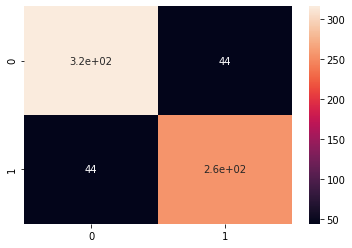

In [32]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(cm, annot=True)
plt.show()

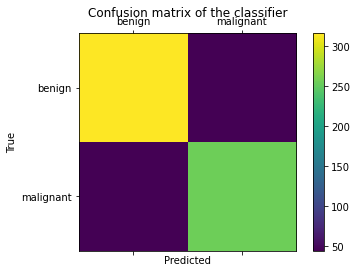

In [33]:
labels = ['benign', 'malignant']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()